# CORD-19 Project: Analysis of COVID-19 Papers
The following notebook aims to perform a parallelized analysis on a dataset containing several COVID-19 related papers. This dataset is part of a real-world research on COVID-19 known as COVID-19 Open Research Dataset Challenge (CORD-19). Datasets and relative information can be retrieved here: https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge

For this project we are going to use two version of the dataset: version 30 (13.63 GB) and version 50 (20.03 GB). The dataset is updated periodically and at present is composed by a staggering 87 GB of papers. We will make use of available resources on CloudVeneto to create a cluster, and Dask to perform the analysis in a parallelized setting

# 0: Setup of the cluster
We created a cluster on CloudVeneto using 4 machines: one of them is the ```dask-scheduler```, the other 3 are ```dask-workers```. In addition to that, to guarantee consistent access to all machines to the dataset, we set up a NFS-server. We access the machines via ```ssh``` protocol.

```bash
ssh -L port:127.0.0.1:port -J username@gate.cloudveneto.it -i ~/.ssh/key.pem ubuntu@ip
```

We changed ```port```, ```username``` and ```ip``` based on our needs. Ip of our machines are:
- ```10.67.22.173``` for the scheduler
- ```10.67.22.150``` for worker 1
- ```10.67.22.153``` for worker 2
- ```10.67.22.183``` for worker 3
- ```10.67.22.227``` for NFS server

## Cluster creation

### GIGI (specifica come hai setuppato lo stesso ambiente python in tutte le macchine)
To connect our machines to the NFS server we run on all of them:

```bash
sudo mount -t nfs 10.67.22.227:/home/ubuntu/nfs /home/ubuntu/data
```


Now we are ready to setup Dask with Python

# 1: Libraries import and Cluster turn-on
In this section we import all the libraries we will use in the notebook. Then we turn on the cluster via Dask

## 1.1: Libraries import

In [ ]:
from dask.distributed import Client, SSHCluster, wait
import ClusterManager as cm 
import dask.bag as db
import dask.dataframe as dd
import dask
import numpy as np
import json
from IPython.display import clear_output
import glob as gl
import os, re, io
from nltk.corpus import stopwords
from nltk import word_tokenize
import nltk
from dask.distributed import Client
import socket
import pandas as pd
import seaborn as sns
import time
import matplotlib.pyplot as plt


## 1.2: Cluster setup
The following command starts off the as-before setupped cluster. To access the dashboard, we create a ```SSH``` tunnel via the command line:

```bash
ssh -L 8797:localhost:8797 -J ncognome@gate.cloudveneto.it -i ~/.ssh/chiave.pem ubuntu@10.67.22.173
```

So that we can then access the Dask Dashboard on http://localhost:8797

We can check the status of the cluster by giving a simple task to perform. We should see the activity log activating in the Dashboard

In [ ]:
import ClusterManager as cm 
client = cm.ClusterStarter()

2025-07-07 16:51:39,938 - distributed.deploy.ssh - INFO - 2025-07-07 16:51:39,938 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-07-07 16:51:39,959 - distributed.deploy.ssh - INFO - 2025-07-07 16:51:39,959 - distributed.scheduler - INFO - State start
2025-07-07 16:51:39,964 - distributed.deploy.ssh - INFO - 2025-07-07 16:51:39,963 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.173:8786
2025-07-07 16:51:41,702 - distributed.deploy.ssh - INFO - 2025-07-07 16:51:41,703 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.153:39213'
2025-07-07 16:51:41,707 - distributed.deploy.ssh - INFO - 2025-07-07 16:51:41,709 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.150:42743'
2025-07-07 16:51:42,095 - distributed.deploy.ssh - INFO - /home/ubuntu/miniconda3/lib/python3.13/site-packages/distributed/worker_memory.py:508: FutureWa

<Client: 'tcp://10.67.22.173:8786' processes=2 threads=2, memory=7.64 GiB>

In [7]:

def who_am_i():
    import socket
    return socket.gethostname()

futures = [client.submit(who_am_i) for _ in range(10)]
results = client.gather(futures)
client


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 3
Total threads: 9,Total memory: 5.70 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39203,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:38817,Total threads: 3
Dashboard: http://127.0.0.1:38561/status,Memory: 1.90 GiB
Nanny: tcp://127.0.0.1:44795,


# 2: Dataset setup
In this part of the Notebook we focus on the available datasets and try to retrieve the correct information from each record. First off, we decide which version of the dataset to analyze and inspect a single JSON's structure:

In [8]:
dataset_version = 30  #pr 50/ whichever we prefer
directory_path = 'archive/document_parses/pdf_json/'#f"data/{dataset_version}/document_parses/pdf_json/"
filenames = gl.glob(directory_path + '*.json')

print(f"Found {len(filenames)} JSON files. \n")

example = filenames[1]
with open(example, 'r') as f:
    data = json.load(f)

print('Each JSON is a dictionary with some keys:')
print(data.keys())

Found 106048 JSON files. 

Each JSON is a dictionary with some keys:
dict_keys(['paper_id', 'metadata', 'abstract', 'body_text', 'bib_entries', 'ref_entries', 'back_matter'])


All of our files should have the following structure:
```json
{
    "paper_id": <str>,                      # 40-character sha1 of the PDF
    "metadata": {
        "title": <str>,
        "authors": [                        # list of author dicts, in order
            {
                "first": <str>,
                "middle": <list of str>,
                "last": <str>,
                "suffix": <str>,
                "affiliation": <dict>,
                "email": <str>
            },
            ...
        ],
        "abstract": [                       # list of paragraphs in the abstract
            {
                "text": <str>,
                "cite_spans": [             # list of character indices of inline citations
                                            # e.g. citation "[7]" occurs at positions 151-154 in "text"
                                            #      linked to bibliography entry BIBREF3
                    {
                        "start": 151,
                        "end": 154,
                        "text": "[7]",
                        "ref_id": "BIBREF3"
                    },
                    ...
                ],
                "ref_spans": <list of dicts similar to cite_spans>,     # e.g. inline reference to "Table 1"
                "section": "Abstract"
            },
            ...
        ],
        "body_text": [                      # list of paragraphs in full body
                                            # paragraph dicts look the same as above
            {
                "text": <str>,
                "cite_spans": [],
                "ref_spans": [],
                "eq_spans": [],
                "section": "Introduction"
            },
            ...
            {
                ...,
                "section": "Conclusion"
            }
        ],
        "bib_entries": {
            "BIBREF0": {
                "ref_id": <str>,
                "title": <str>,
                "authors": <list of dict>       # same structure as earlier,
                                                # but without `affiliation` or `email`
                "year": <int>,
                "venue": <str>,
                "volume": <str>,
                "issn": <str>,
                "pages": <str>,
                "other_ids": {
                    "DOI": [
                        <str>
                    ]
                }
            },
            "BIBREF1": {},
            ...
            "BIBREF25": {}
        },
        "ref_entries":
            "FIGREF0": {
                "text": <str>,                  # figure caption text
                "type": "figure"
            },
            ...
            "TABREF13": {
                "text": <str>,                  # table caption text
                "type": "table"
            }
        },
        "back_matter": <list of dict>           # same structure as body_text
    }
}
```
We have to handle them carefully, since there can be missing values

## 2.1: Dask bag
Dask bags are one of the available data structures on Dask. They provide very generalized computations, and interpret their content as lists (the i-th element can be accessed via command, and also there can be duplicated arguments). For the first algorithm, this is our data structure of choice

In [9]:
partition_size = 200
files_to_take = len(filenames)
filenames = filenames[:files_to_take]

# function to load files
def load_json_file(path):
    with open(path) as f:
        return json.load(f)

json_bag = db.from_sequence(filenames, npartitions=partition_size).map(load_json_file)
count = json_bag.count().compute()
print('JSON bag contains',count,'files')

JSON bag contains 106048 files


# 3: Word counter distributed algorithm
Our first real task is about a Word counter. Our goal is to determine how many times a single word appears in every document (and then in the full dataset). To achieve this we setup an algorithm divided in two phases:

**Map phase**: For each document $D_i$ we will produce a set of intermediate pairs $(w,cp(w))$, one per each word $w$ in a given document $D_i$, where $cp(w)$ refers to the number of occurrences of $w$ in $D_i$.

**Reduce phase**: For each word $w$, gather all pairs previously computed and return a final pair $(w,c(w))$ where $c(w)$ refers to the **total** number of occurrences of $w$ across all documents.  

The algorithm will be executed on the full text of all the papers. To get the full text, we first need to access the ```body-text``` attribute of each JSON and concatenate the strings in them.

In [11]:
# download stopwords
nltk.download('stopwords') 

[nltk_data] Downloading package stopwords to /home/luca3/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [12]:
# english common stopwords
en_stopwords = stopwords.words("english")

# function to compute the words in a text
def words_in_body(body_text):

    # clean text
    string = " ".join([txt['text'] for txt in body_text]).lower() # join all paragraphs in lowercase

    string = re.sub(r"[^a-z\s]", " ", string) # remove numbers and punctuations

    tokens = string.split() # tokenize on whitespaces (avoids words splitting)

    # remove stopwords, common words and single letters
    stop_words = set(en_stopwords) | {"fig","figure","et","al","results","also",
                                      "used","using","may","one","two","de","however"}
    
    stop_words |= set("p o i u y t r e w q l k j h g f d s a z x c v b n m".split())
    filtered_words = [w for w in tokens if w not in stop_words]

    words, words_counts = np.unique(filtered_words, return_counts=True)

    return [{"word": str(i) , "n_counts": int(j)} for i,j in zip(words,words_counts)]
    

We separately perform map and reduce phases in the following cell

In [13]:
# extract each document's body text
body_texts = json_bag.pluck("body_text")

# count words (map phase)
words_counts = body_texts.map(words_in_body)

# increment counters through all documents
def increment(tot, x):
    return tot + x['n_counts']

# using foldby to get all occurrences of each 'word' (reduce phase)
words_counted_reduce = words_counts.flatten().foldby('word', 
                                                     binop=increment, 
                                                     initial=0, 
                                                     combine = lambda x,y: x+y, 
                                                     combine_initial=0
                                                    )


Dask is **lazy**: it does not perform any computation if it is not explicily said to do so. We compute the task and show the results in a histogram:

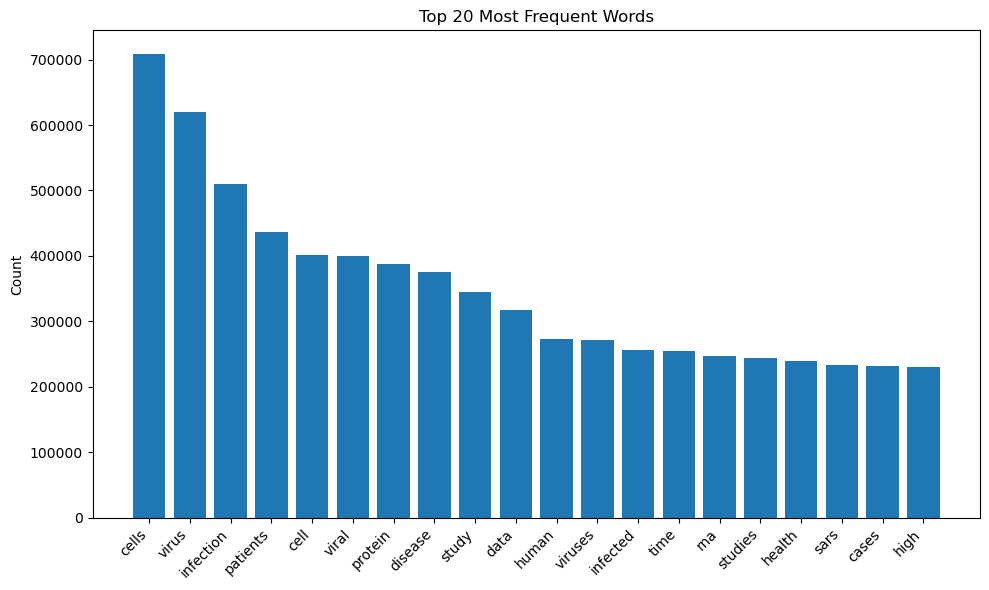

In [ ]:
# Convert to a list of (word, count) tuples and compute
word_counts = words_counted_reduce.compute()

# Sort top 20 locally
sorted_words = sorted(word_counts, key=lambda x: x[1], reverse=True)[:20]

# Unzip and plot
words, counts = zip(*sorted_words)

plt.figure(figsize=(10, 6))
plt.bar(words, counts)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Count")
plt.title("Top 20 Most Frequent Words")
plt.tight_layout()
plt.show()

## 3.1: Grid search on hyperparameters
We want to be able to perform tasks with the highest speed possible. Hyperparameter configuration is strictly dependent on the dataset and its structure, and it's hard to infer a-priori what values they should take. For this reason, we repeat the previous analysis changing the number of available workers and the number of partitions, to see which combination performs best. We expect to have better results with 3 workers, and a number of partitions that is manageble by our workers, but at the same time that include a high number of files

In [ ]:
def configuration_time(n_partitions):
    # take the starting time
    start_time = time.time()
    # configure the bag
    json_bag = db.from_sequence(filenames, npartitions=n_partitions).map(load_json_file)
    # perform the count(map phase)
    words_counts = json_bag.pluck("body_text").map(words_in_body)
    # merge the counts (reduce phase)
    words_counts_reduce = words_counts.flatten().foldby('word', 
                                                     binop=increment, 
                                                     initial=0, 
                                                     combine = lambda x,y: x+y, 
                                                     combine_initial=0
                                                    ).compute() # here we compute to really perform the operation
    end_time = time.time()
    diff_time = end_time - start_time
    print(f'With {n_partitions} partitions, computation time: {round(diff_time,2)}s')

    # delete the objects (save space)
    del json_bag
    del words_counts
    del words_counts_reduce
    
    return diff_time
    

In [ ]:
# ensure that the cluster is closed
client.close()
cluster.close()
# setup DataFrame for saving results
df_times = pd.DataFrame(np.nan, index=partitions_list, columns=possible_workers)

# machines' IPs
scheduler = "10.67.22.173" # 10.67.22.173 -- vm : mapdb-group9-2
worker1 = "10.67.22.153" # vm : mapdb-group9-2
worker2 = "10.67.22.150" # vm : mapdb-group9-3
worker3 = "10.67.22.183" # vm : mapdb-group9-4

We ran the following cell a number of times to get all the data needed for completing the grid

In [ ]:

# Parameters
partitions_list = [1,10, 20, 50, 100, 500]#[1, 5, 10, 25, 50, 100, 250, 500, 1000]
possible_workers = [1,2,3]  # Try others one at a time
chosen_n_workers = possible_workers[2]
ip_list = [scheduler, worker1, worker2, worker3]  # Assume these are defined as strings

scheduler = "10.67.22.173" # 10.67.22.173 -- vm : mapdb-group9-2
worker1 = "10.67.22.153" # vm : mapdb-group9-2
worker2 = "10.67.22.150" # vm : mapdb-group9-3
worker3 = "10.67.22.183" # vm : mapdb-group9-4

ip_list = [scheduler, worker1, worker2, worker3]

try: ## This starts the cluster but if it was started and not closed, this will raise error, so
    cluster = SSHCluster(
        ip_list[:(chosen_n_workers+1)],
        connect_options={"known_hosts": None},
        worker_options={"memory_limit":"3.8GB"},
        scheduler_options={"port": 8786, "dashboard_address": ":8797"},
    )
    client = Client(cluster)
except RuntimeError: # this is how to resume the cluster
    clear_output()
    client = Client(scheduler + ':8786') # restarts the cluster, by simply recalling it

display(client)

# Time each partition count
times_list = []
print(f'\nTrying {num_workers} workers...')
for partitions in partitions_list:
    t = configuration_time(partitions)
    times_list.append(t)

df_times[chosen_n_workers] = times_list

# Cleanup: close client and cluster explicitly
client.close()
cluster.close()

2025-07-02 23:30:58,029 - distributed.deploy.ssh - INFO - 2025-07-02 23:30:58,029 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-07-02 23:30:58,051 - distributed.deploy.ssh - INFO - 2025-07-02 23:30:58,051 - distributed.scheduler - INFO - State start
2025-07-02 23:30:58,055 - distributed.deploy.ssh - INFO - 2025-07-02 23:30:58,055 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.173:8786
2025-07-02 23:30:59,697 - distributed.deploy.ssh - INFO - 2025-07-02 23:30:59,699 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.150:43917'
2025-07-02 23:31:00,036 - distributed.deploy.ssh - INFO - 2025-07-02 23:31:00,041 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.153:38291'
2025-07-02 23:31:00,055 - distributed.deploy.ssh - INFO - 2025-07-02 23:31:00,057 - distributed.diskutils - INFO - Found stale lock file and directory '/

<Client: 'tcp://10.67.22.173:8786' processes=2 threads=2, memory=7.08 GiB>


Trying 2 workers...
With 1 partitions, computation time: 1073.71s
With 10 partitions, computation time: 398.48s
With 20 partitions, computation time: 420.4s
With 50 partitions, computation time: 357.93s
With 100 partitions, computation time: 377.76s
With 500 partitions, computation time: 421.53s


When the grid is complete, we plot it:

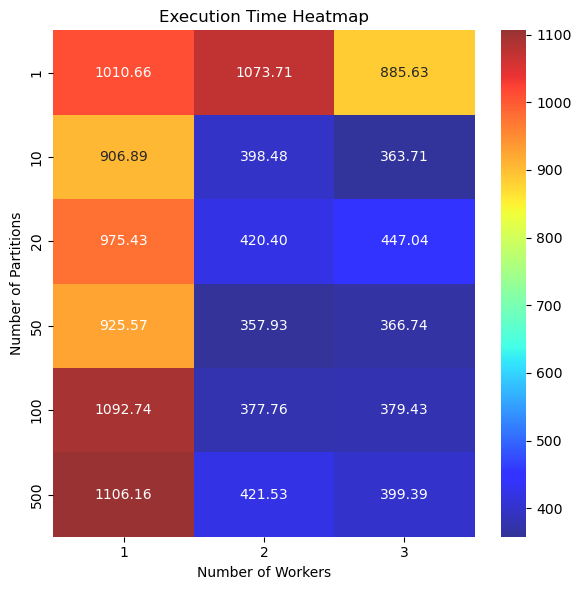

In [ ]:
plt.figure(figsize=(6, 6))
sns.heatmap(final_df, annot=True, fmt=".2f", cmap="jet", alpha = 0.8)
plt.title("Execution Time Heatmap")
plt.xlabel("Number of Workers")
plt.ylabel("Number of Partitions")
plt.tight_layout()
#plt.savefig("Grid_search_execution_times.png")
plt.show()

# 4: Identifying the worst and best represented countries/institutes in the research


In this part of the project the goal is to identify the best and worst represented countries/institutes in the research of COVID19.
To get this information, we extrapolate for each author of each paper (JSON file) the country and the institute of affiliation.


Then, we create a Dask DataFrame, containing two columns: "country" and "institution". From then we perform a count with a groupby() to get the information we need.

Finally, we plot the results as a bar plot.


The following is the structure of the JSON files:  
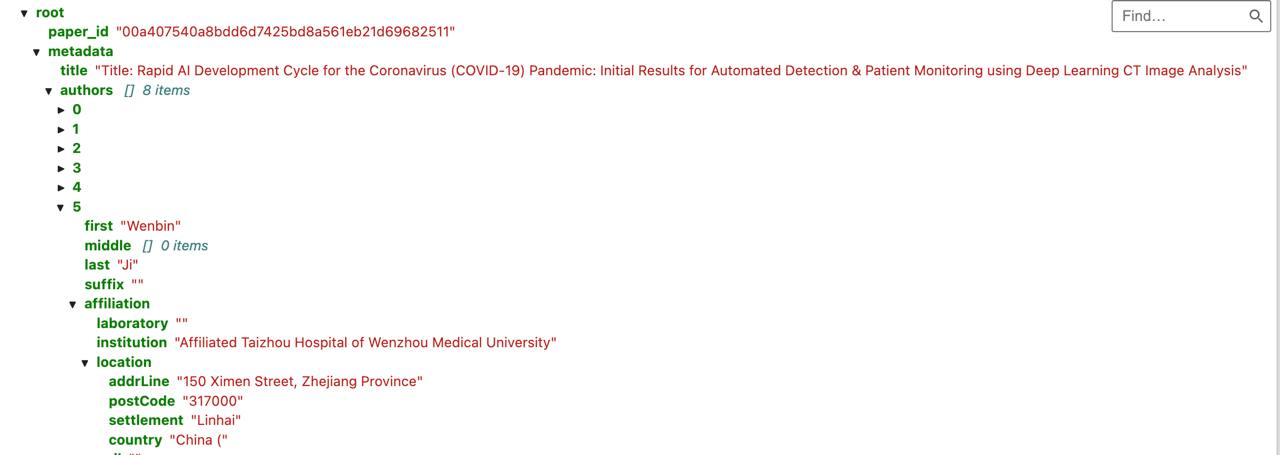

As we can see, the information that we need is under metadata/authors/affiliation/location/country. And a paper could have many authors. So firstly,  we create a tuple with all the authors of the paper, then for all the authors in the tuple, we extrapolate the country and the location. The final result is two lists, one with the countries and another with the institutions.

 

In [ ]:
def extract_country(filenames):
    with open(filenames, 'r') as f: 
        data = json.load(f)
    authors = (
        data
        .get("metadata", {})
        .get("authors", []) 
    )

    countries = []
    for author in authors:
        country = (author.get("affiliation", {})
               .get("location", {})
               .get("country"))
        if country is not None and country != "":  
            countries.append(country)
    
    institutions = [
            author.get("affiliation", {})
            .get("institution", None) for author in authors 
                if author.get("affiliation", {}).get("institution") 
                is not None ]
            

   
    return countries , institutions

At this point we want to create the data frame containing the countries and institutions for each file. So we perform the `map` , to apply the function lazily and in parallel over all the elements of the bag.

In [ ]:
# Create bag and dataframe
npartitions = 50
json_df = (
    db.from_sequence(filenames, npartitions=npartitions)
      .map(extract_country)
      .to_dataframe(columns=["country", "institutions"])
)

Many countries are reported with more then one name. To avoid repetitions, we made a dictionary to use later to clean the data and to aggregate each name of a country under a single one. 

In [ ]:
# country mapping
country_mapping = {
    'USA': 'United States',
    'United States of America': 'United States',
    'US': 'United States',
    'USA, USA': 'United States',
    'Usa': 'United States',
    'Alabama': 'United States',
    'New Jersey': 'United States',
    'UK': 'United Kingdom',
    'UK A R': 'United Kingdom',
    'Great Britain': 'United Kingdom',
    'PR China': 'China', 
    'People\'s Republic of China': 'China',
    'P.R. China': 'China',
    'PR China': 'China',
    'China, China': 'China',
    'P. R. China': 'China',
    'China A R': 'China',
    'Republic of Korea': 'South Korea',
    'Korea': 'South Korea',
    'España': 'Spain',
    'the Netherlands': 'The Netherlands',
    'Taiwan, ROC': 'Taiwan',
    'Taiwan ROC': 'Taiwan',
    'Italia': 'Italy',
    'Russian Federation': 'Russia', 
    'CANADA': 'Canada',
    'australia': 'Australia',
    'UAE': 'United Arab Emirates',
    'France Key Words': 'France',
    'Democratic Republic of the Congo': 'Democratic Republic of Congo', 
    'Congo': 'Democratic Republic of Congo', 
    'The Gambia': 'Republic of The Gambia'
}

At this point we make the data frame columns one dimensional and data clean the country names and institutions, dropping the no-alphabetical characters, spaces , etc and macking sure the different names of a country are aggregated under a single one, applying the dictionary country_mapping. We still didn't compute anything yet, it's all still just a Dask plan. 

In [ ]:
def process_and_clean(pdf):
    # Explode both columns
    pdf = pdf.explode('country')
    pdf = pdf.explode('institutions')
    pdf = pdf[pdf['institutions'].fillna('').str.strip() != '']
    pdf['country_clean'] = pdf['country'].replace(country_mapping)
    pdf['country_clean'] = pdf['country_clean'].astype(str)
    mask = (
        pdf['country_clean'].notna() & 
        (pdf['country_clean'] != 'nan') &  
        pdf['country_clean'].str.match(r'^[a-zA-Z\s]+$', na=False)
    )
    pdf = pdf[mask]
    
    return pdf

# Apply all transformations
json_df = json_df.map_partitions(process_and_clean)
json_df = json_df.persist()

At this point, we perform the aggregation with group by and finally we compute the results. The plan we defined previously will be executed. The result is partitioned in 3 using `split_out = 3`, to make sure none of the workers will get too large partitions compared to others and enhance task parallelism.

In [ ]:
# Aggregations
country_counts = (
    json_df.groupby("country_clean")
           .size(split_out=3)
           .to_frame('count')
           .reset_index()
           .sort_values('count', ascending=False)
           .compute()  # Compute 
)

institutions_counts = (
    json_df.groupby("institutions")
           .size(split_out=3)
           .to_frame('count')
           .reset_index()
           .sort_values('count', ascending=False)
           .compute()  # Compute 
)

At this point we make the bar plot. We consider only those countries with more then 500 counts to avoid bad-formatted names. 

<Figure size 1500x800 with 0 Axes>

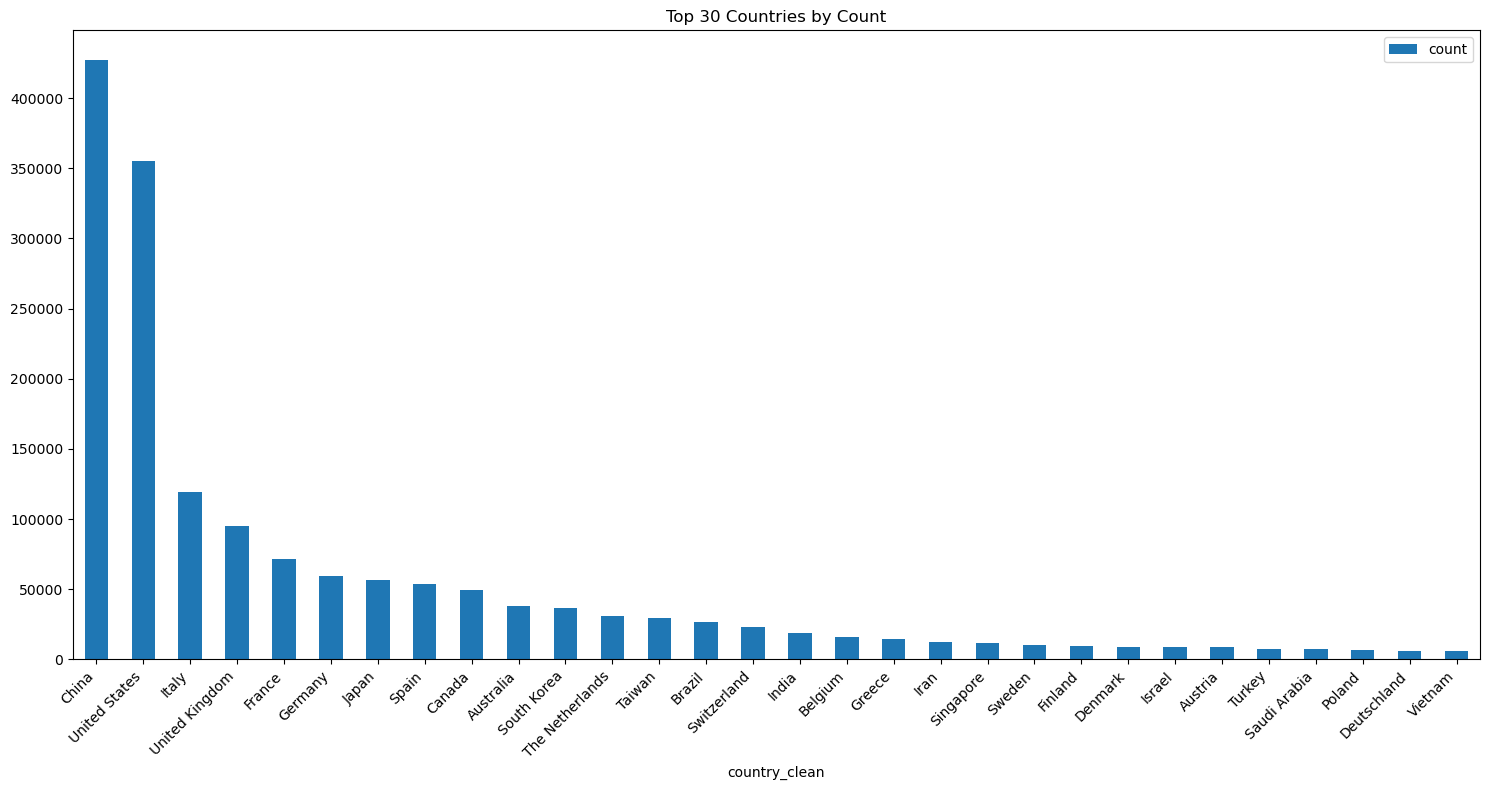

<Figure size 1500x800 with 0 Axes>

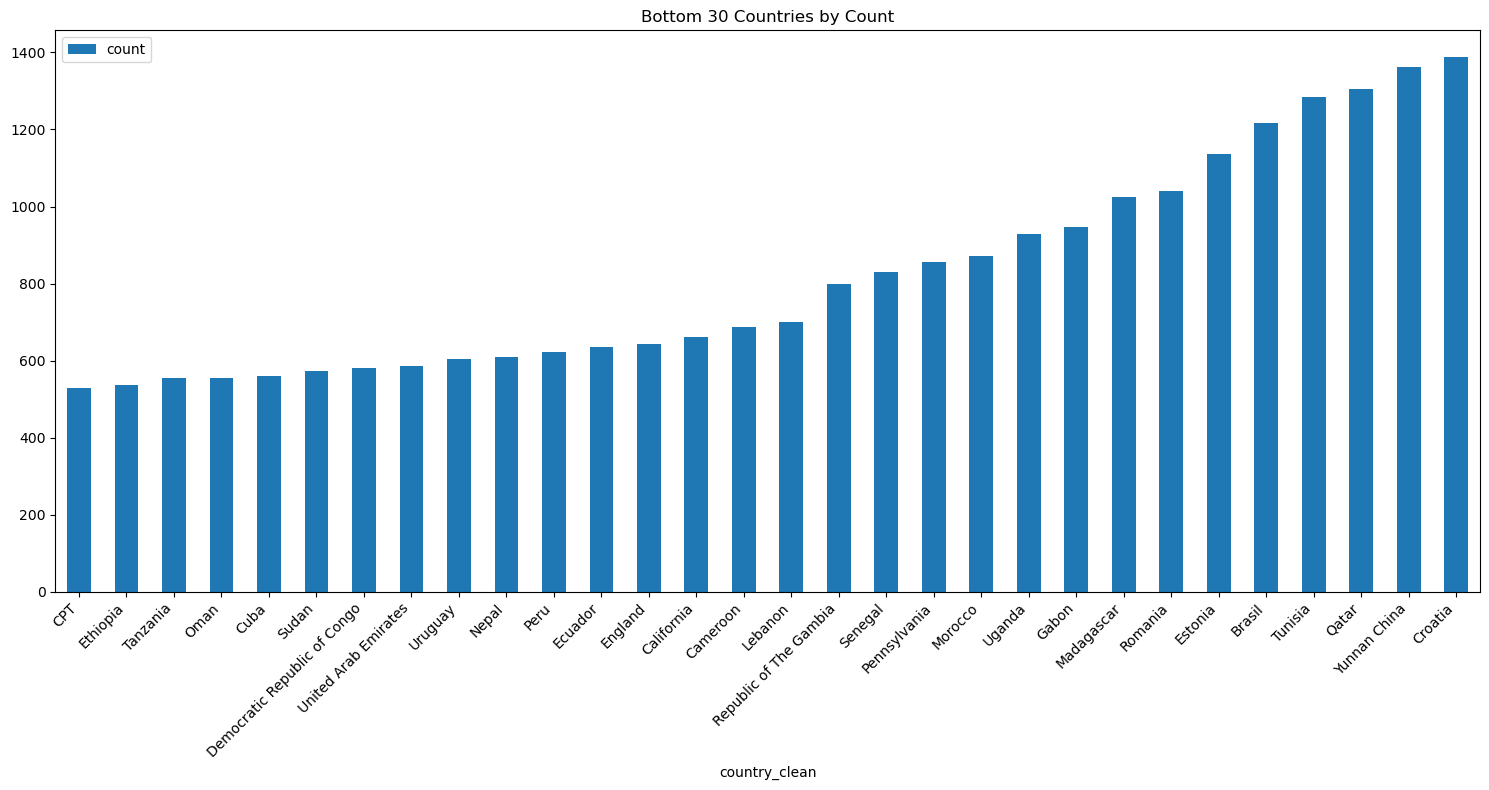

In [ ]:
counts_df = country_counts[country_counts['count'] >= 500]

# Top 30 countries
plt.figure(figsize=(15, 8))
counts_df.head(30).plot(x='country_clean', y='count', kind='bar', figsize=(15, 8))
plt.title('Top 30 Countries by Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Bottom 30 countries
plt.figure(figsize=(15, 8))
counts_df.tail(30).iloc[::-1].plot(x='country_clean', y='count', kind='bar', figsize=(15, 8))
plt.title('Bottom 30 Countries by Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

<Figure size 1500x800 with 0 Axes>

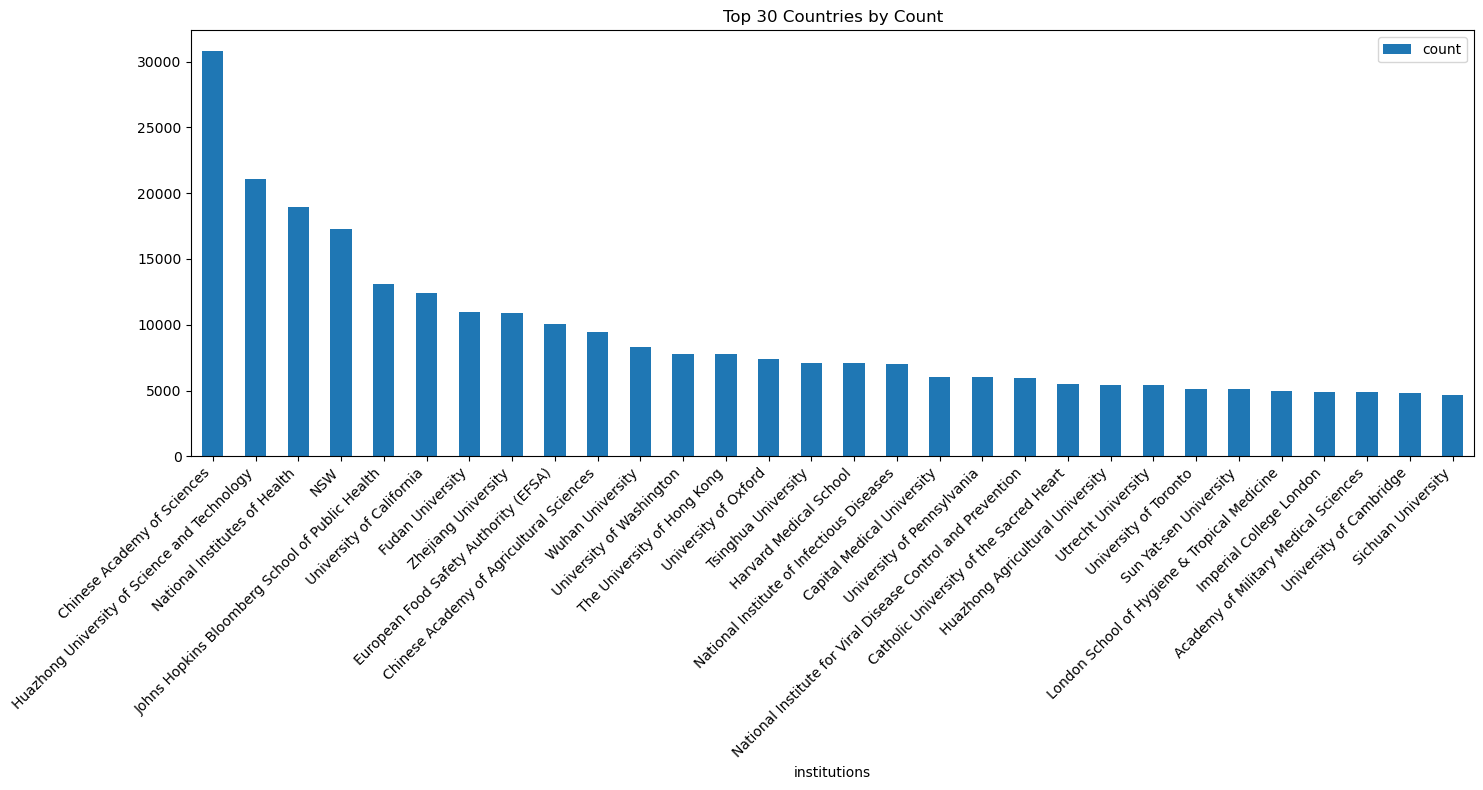

<Figure size 1500x800 with 0 Axes>

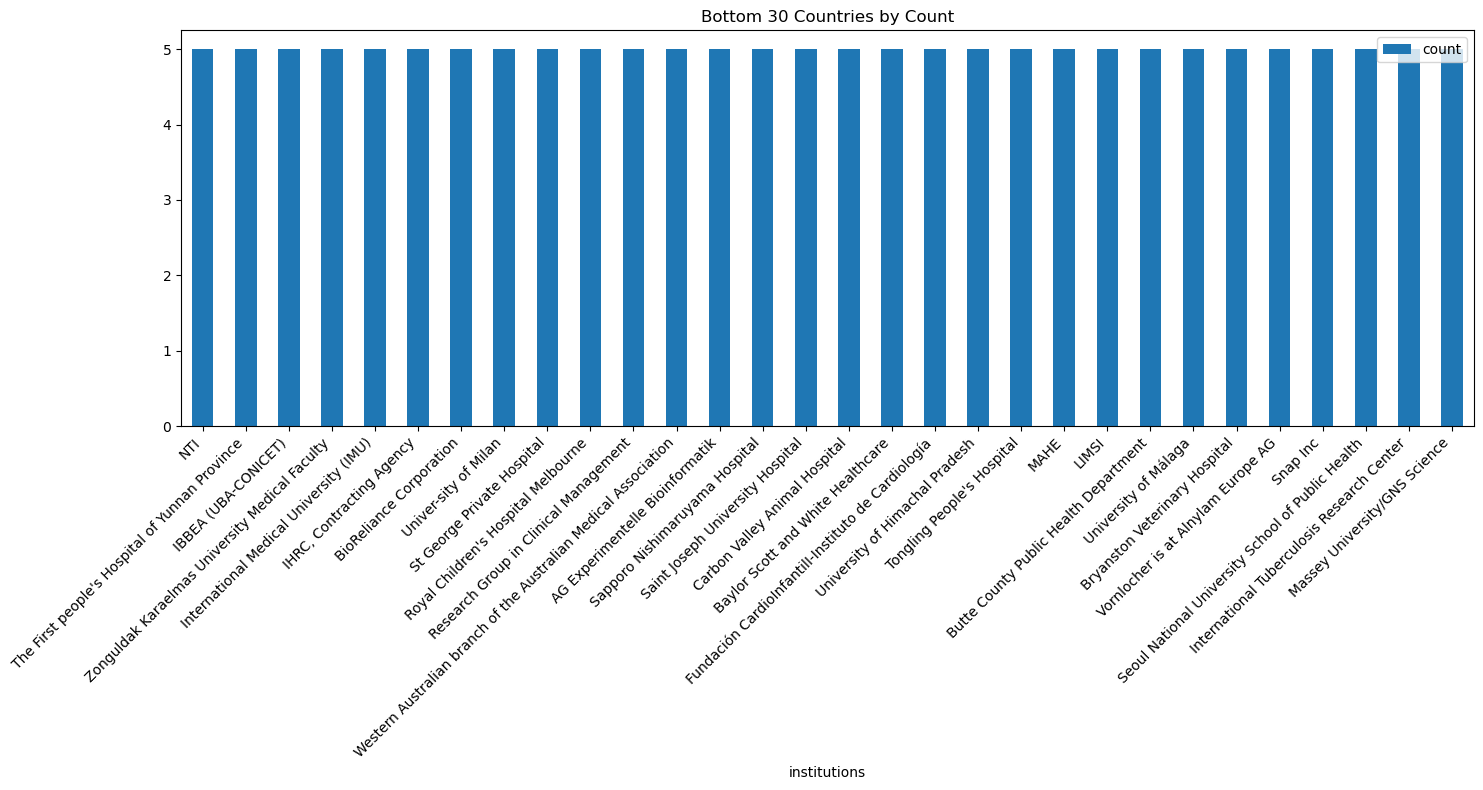

In [ ]:
institutions_df = institutions_counts[institutions_counts['count'] >= 5]

plt.figure(figsize=(15, 8))
institutions_df.head(30).plot(x='institutions', y='count', kind='bar', figsize=(15, 8))
plt.title('Top 30 Countries by Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Bottom 30 institurions
plt.figure(figsize=(15, 8))
institutions_df.tail(30).iloc[::-1].plot(x='institutions', y='count', kind='bar', figsize=(15, 8))
plt.title('Bottom 30 Countries by Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Benchmarking with different number of partitions and workers 

In [ ]:
partition_size = 200
files_to_take = 10000
filenames = filenames[:files_to_take]



print(f"Found {len(filenames)} JSON files. \n")

example = filenames[1]
with open(example, 'r') as f:
    data = json.load(f)

print('Each JSON is a dictionary with some keys:')
print(data.keys())

Found 10000 JSON files. 

Each JSON is a dictionary with some keys:
dict_keys(['paper_id', 'metadata', 'abstract', 'body_text', 'bib_entries', 'ref_entries', 'back_matter'])


In [ ]:
def configuration_time(n_partitions):
    # take the starting time
    start_time = time.time()
    # configure the bag and data frame
    json_df = (
        db.from_sequence(filenames, npartitions=n_partitions)
       .map(extract_country)
       .to_dataframe(columns=["country", "institutions"])
    )
    json_df = json_df.map_partitions(process_and_clean)
    json_df = json_df.persist()
    
    country_counts = (
    json_df.groupby("country_clean")
           .size(split_out=3)
           .to_frame('count')
           .reset_index()
           .sort_values('count', ascending=False)
           .compute()   
    )

    end_time = time.time()
    diff_time = end_time - start_time
    print(f'With {n_partitions} partitions, computation time: {round(diff_time,2)}s')

    # delete the objects (save space)
    del json_df
    del country_counts
    
    
    return diff_time
    

In [ ]:
# ensure that the cluster is closed
# parameters
partitions_list = [1,10, 20, 50, 100, 500]
possible_workers = [1,2,3]  
# setup DataFrame for saving results
df_times = pd.DataFrame(np.nan, index=partitions_list, columns=possible_workers)

# machines' IPs
scheduler = "10.67.22.173" # 10.67.22.173 -- vm : mapdb-group9-2
worker1 = "10.67.22.153" # vm : mapdb-group9-2
worker2 = "10.67.22.150" # vm : mapdb-group9-3
worker3 = "10.67.22.183" # vm : mapdb-group9-4

In [ ]:

chosen_n_workers = possible_workers[2]
ip_list = [scheduler, worker1, worker2, worker3]  
ip_list = ip_list[:(chosen_n_workers+1)]

try: ## This starts the cluster but if it was started and not closed, this will raise error, so
    cluster = SSHCluster(
        ip_list,
        connect_options={"known_hosts": None},
        worker_options={"memory_limit":"3.8GB"},
        scheduler_options={"port": 8786, "dashboard_address": ":8797"},
    )
    client = Client(cluster)
except RuntimeError: # this is how to resume the cluster
    clear_output()
    client = Client(scheduler + ':8786') # restarts the cluster, by simply recalling it

display(client)

# get the time for each partition count
times_list = []
num_workers = chosen_n_workers
print(f'\nTrying {num_workers} workers...')
for partitions in partitions_list:
    t = configuration_time(partitions)
    times_list.append(t)

df_times[chosen_n_workers] = times_list

# close client and cluster 
client.close()
#cluster.close()

2025-07-07 17:41:29,032 - distributed.deploy.ssh - INFO - 2025-07-07 17:41:29,032 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-07-07 17:41:29,054 - distributed.deploy.ssh - INFO - 2025-07-07 17:41:29,054 - distributed.scheduler - INFO - State start
2025-07-07 17:41:29,058 - distributed.deploy.ssh - INFO - 2025-07-07 17:41:29,058 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.173:8786
2025-07-07 17:41:30,465 - distributed.deploy.ssh - INFO - 2025-07-07 17:41:30,474 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.150:39201'
2025-07-07 17:41:30,467 - distributed.deploy.ssh - INFO - 2025-07-07 17:41:30,474 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.153:46533'
2025-07-07 17:41:30,610 - distributed.deploy.ssh - INFO - 2025-07-07 17:41:30,615 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.18

<Client: 'tcp://10.67.22.173:8786' processes=2 threads=2, memory=7.08 GiB>


Trying 3 workers...
With 1 partitions, computation time: 10.93s
With 10 partitions, computation time: 4.49s
With 20 partitions, computation time: 5.37s
With 50 partitions, computation time: 4.3s
With 100 partitions, computation time: 5.5s
With 500 partitions, computation time: 12.09s


In [ ]:
print(df_times)

             1          2          3
1    10.064474  11.513002  10.929214
10    8.208864   4.337759   4.493828
20    8.483633   5.030532   5.370704
50   10.257874   5.421121   4.300078
100  13.380385   7.408975   5.501901
500  29.526642  16.741402  12.093254


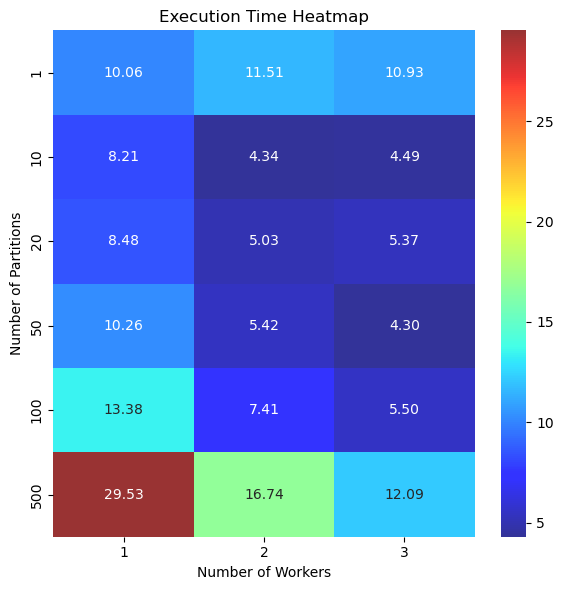

In [ ]:


plt.figure(figsize=(6, 6))
sns.heatmap(df_times, annot=True, fmt=".2f", cmap="jet", alpha = 0.8)
plt.title("Execution Time Heatmap")
plt.xlabel("Number of Workers")
plt.ylabel("Number of Partitions")
plt.tight_layout()
#plt.savefig("Grid_search_execution_times.png")
plt.show()

# 5: Obtaining embeddings for Paper Titles
In Natural Language Processing, a common tecnique for text analysis is to transform text into numerical vectors, where each vector represents a word in a document. At the end of this operation, the document is transformed in a list of vectors, or a matrix ```n x m``` where ```n``` is the number of words in the document and ```m``` is the size of the vector representing each word ```n```.

For this part, we took a pre-trained English model. The model is a large dictionary whose entries are in the form ```key:vector```, where each ```key``` corresponds to a word. This way we can easily link each word to its own vector. We will map the dataset in a DataFrame composed of ```paper-id``` (```pid```) and ```title-embedding``` (```vec```), so we link each document's id to the representation of its title in the vector space. 

## 5.1: Grid search on hyperparameters
As previously done for the word counter algorithm, we want to look for the best setting that lets us perform the task as quickly as possible. The way we have set up the functions lets us set a flag that lets us perform a benchmark. Our parameter space is the following:

```python
worker_list = [3,2,1]
title_pid_parts = [3]
wiki_blksize = [32e6,64e6,128e6] 
filt_wiki = [3] 
```
For time reasons we did not extend the search over title_pid_parts and filt_wiki. These should be the least influential parameters. Having only 2 parameters to look for, though, allows us to plot the results in a grid

In this section, after the benchmark, we took only a small portion of the dataset, with the sample command:
```python
else:
        sampled_raw = the_word_and_the_vec.sample(frac=0.002)
        sampled_pids = set(sampled_raw['pid'].compute().tolist())
```
This allows us to perform easy computations with ```numpy``` (more on this later)

In [7]:
# functions for Part 5

# embedding produces lists of pid, titles and vectors relative to titles
def nlp_embedding(num_workers:int,
                            title_pid_partitions:float,
                            wiki_blksize:float,
                            filt_partitions:float,
                            v_dataset:int,
                            benchmark:bool):
    
    client = cm.ClusterStarter(nworkers=num_workers)
    dataset_version= v_dataset
    modelpath = '/home/ubuntu/data/NLP_model/wiki.en.vec' ## Model location
    metadata_path = f'/home/ubuntu/data/{dataset_version}/metadata.csv' # metadata location

    def split_like_oleg(inputi:str)->list:
        """
        splits and lowers string
        """
        if type(inputi) != type('hey'): return []
        return inputi.lower().split()

    metadatacsv = dd.read_csv(metadata_path,   # Reading metadata.csv
                            blocksize=32e6, ## so it is divided in 3,more partitions make no sense
                            dtype={'title': str, 'sha': str, 'pmcid': str, 'arxiv_id': str, 'pubmed_id': str, 'who_covidence_id': str}
                            ).loc[:,['sha', 'title','pmcid']]

    metadatacsv['pid'] = metadatacsv['sha'].fillna(value=metadatacsv['pmcid']).astype(str) # sometimes pdf_jsonID is missing, we will use from PMC_json
    title_pid = metadatacsv.drop(columns=['sha','pmcid']) # don't need those
    title_pid['title'] = title_pid['title'].apply(split_like_oleg, meta=('title', 'object')) # turning every title-string into title-list
    # save full titles
    full_titles = title_pid[['pid', 'title']].map_partitions(
        lambda df: df.assign(full_title=df['title'].map(' '.join))
    )[['pid', 'full_title']].drop_duplicates()

    
    title_pid = title_pid.explode('title').repartition(npartitions=title_pid_partitions) # exploding every list + repartitioning


    uni_words = dd.from_pandas(pd.DataFrame({'word':title_pid['title'].unique()})).astype({'word': str})#unique words in all titles

    del metadatacsv 
    client.run(gc.collect) # memory management
    def master_splinter(inputi:str) -> dict:
        """
        Splits strings and turns them in dicts made like {'word': [vector]}
        """
        line = inputi.rstrip().split(' ')
        if len(line) < 301: return None # just to be sure
        elif len(line[0]) <= 2: return None # remove header
        else:
            return dict({'word' :str(line[0]), 'vec': list(map(float,line[1:])) })

    def usgarrista(inputi):
        """
        Returns True if  NoneType
        """
        return inputi is None 

    wiki_vec = db.read_text(modelpath,# loading model
                            blocksize=wiki_blksize,
                            encoding='utf-8',
                            errors='strict',
                            linedelimiter='\n',
                            collection=True
                            ).map(
                                master_splinter
                                ).remove(
                                    usgarrista
                                    ).to_dataframe(
                                        meta= {'word': str, 'vec': 'object'}
                                    )
    wiki_vec['word'] = wiki_vec['word'].astype(str)

    filtered_wiki = wiki_vec.merge(uni_words, # intersecting model with unique words, so we will use just what we need
                                    on='word',
                                    how='inner'
                                    ).repartition(
                                        npartitions=filt_partitions)
    del wiki_vec, master_splinter, usgarrista, uni_words, modelpath, metadata_path # memory management
    client.run(gc.collect)

    def list_or_nothing(objecto): # some words do not appear in model: annihilated
        if objecto is None: return []
        if isinstance(objecto, list): return objecto
        return []

    the_word_and_friends = title_pid.merge(filtered_wiki, how='left', left_on='title',right_on='word') # merging exploded titles w/ filtered wiki
    the_word_and_the_vec = the_word_and_friends[['pid','vec']].copy() # some cleaning/refining
    the_word_and_the_vec['vec'].apply(list_or_nothing, meta=('vec', 'object'))
    del the_word_and_friends # memory management
    client.run(gc.collect)

    
    if benchmark:
        nlp_bible = the_word_and_the_vec.groupby('pid')['vec'].apply(list, meta=('vec','object')).reset_index().persist()
        wait(nlp_bible) # wait for persist to compute the df
        del nlp_bible, the_word_and_the_vec # memory management of the cluster if benchmarking
        client.run(gc.collect)
        client.shutdown()
        return 'worked'
    else:
        sampled_raw = the_word_and_the_vec.sample(frac=0.002)
        sampled_pids = set(sampled_raw['pid'].compute().tolist())
        
        sampled_pids_set = set(sampled_pids)  # Convert list to set for faster lookup

        full_titles = full_titles.map_partitions(
            lambda df: df[df['pid'].isin(sampled_pids_set)]
        ).compute()

        nlp_bible_partial = sampled_raw.groupby('pid')['vec'].apply(list, meta=('vec', 'object')).reset_index()
        partial_result = nlp_bible_partial.compute()
        
        pids = partial_result['pid'].tolist()
        vectors = partial_result['vec'].tolist()
        
        return client, pids, vectors, full_titles

def benchmark():
    worker_list = [3,2,1]
    title_pid_parts = [3] #, 6, 9]
    wiki_blksize = [32e6,64e6,128e6] #,512e6,1e9] #6 gigabytes, we have 4 GB x worker, wiki suggests btween 100 and 1 gb
    filt_wiki = [3] #,6,9]
    times = []
    check = []
    param_list = []
    # things to add? CPU Load?
    for title in title_pid_parts:
        for worker in worker_list:        
            for blksz in wiki_blksize:
                for filt_wikiii in filt_wiki:
                    start = time.time()
                    a = nlp_embedding(num_workers=worker,
                     title_pid_partitions=title,
                      wiki_blksize= blksz,
                       filt_partitions=filt_wikiii, 
                        v_dataset=30,
                         benchmark=True )
                    end = time.time()
                    diff_time = end - start
                    #times.append(diff_time)
                    #check.append(a)

                    params = {
                        'workers': worker,
                        'wiki_blksize': blksz,
                        'title_pid_parts': title,
                        'filt_wiki': filt_wikiii,
                        'time': diff_time,
                        'check': a
                    }
                    param_list.append(params)
    
    return param_list #times, check, params


Taken 1000 files


In [ ]:
# benchmark
params = benchmark()
df = pd.DataFrame(params)
# time with workers as rows and wiki_blksize as columns
pivot_df = df.pivot(index='workers', columns='wiki_blksize', values='time')
pivot_df = pivot_df.sort_index().sort_index(axis=1)

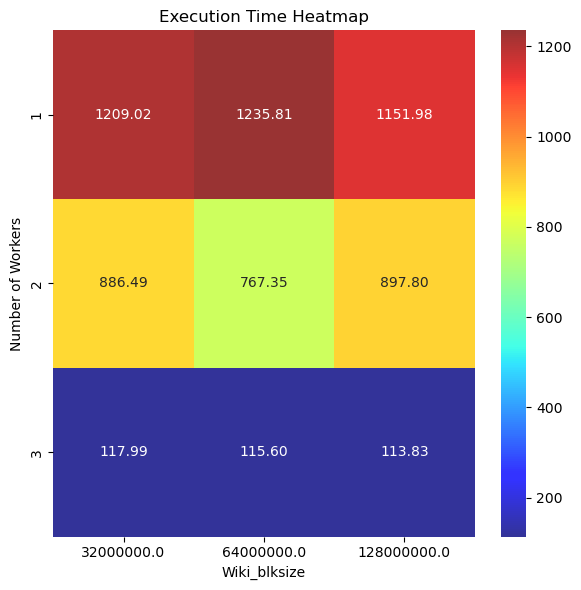

In [ ]:

plt.figure(figsize=(6, 6))
sns.heatmap(pivot_df, annot=True, fmt=".2f", cmap="jet", alpha = 0.8)
plt.title("Execution Time Heatmap")
plt.ylabel("Number of Workers")
plt.xlabel("Wiki_blksize")
plt.tight_layout()
#plt.savefig("Grid_search_execution_times.png")
plt.show()

In [ ]:
times = [x['time'] for x in params]
times = np.array(times)
best_time_index = np.argmin(times)
best_time = times[best_time_index]
best_params = params[best_time_index]

print(f'We got best time: {round(best_time,3)}s with params: \n{best_params}')

We got best time: 113.829s with params: 
{'workers': 3, 'wiki_blksize': 128000000.0, 'title_pid_parts': 3, 'filt_wiki': 3, 'time': 113.82907319068909, 'check': 'worked'}


In [ ]:
best_params = {'workers': 3, 'wiki_blksize': 128000000.0, 'title_pid_parts': 3, 'filt_wiki': 3, 'time': 113.82907319068909, 'check': 'worked'}

## 5.2: Setup the best parameters and see the results
We want to setup the cluster correctly for the last part and check the representation of the titles as vectors

In [ ]:
n_workers = best_params['workers']
title_pid_partitions = best_params['title_pid_parts']
wiki_blksize = best_params['wiki_blksize']
filt_partitions = best_params['filt_wiki']
benchmark = False

# we remove the benchmark flag to get the results and not delete them
client, pid, vectors, _ = nlp_embedding(num_workers=n_workers,
                                        title_pid_partitions=title_pid_partitions,
                                        wiki_blksize=wiki_blksize,
                                        filt_partitions=filt_partitions,
                                        v_dataset=dataset_version,
                                        benchmark=benchmark
                                       )



<Client: 'tcp://10.67.22.173:8786' processes=3 threads=3, memory=11.46 GiB>

Task exception was never retrieved
future: <Task finished name='Task-60857' coro=<Client._gather.<locals>.wait() done, defined at /home/ubuntu/miniconda3/lib/python3.13/site-packages/distributed/client.py:2377> exception=AllExit()>
Traceback (most recent call last):
  File "/home/ubuntu/miniconda3/lib/python3.13/site-packages/distributed/client.py", line 2386, in wait
    raise AllExit()
distributed.client.AllExit


In [ ]:
print(pid[0])
print(vectors[0])

00d1165856c978d9b09bee5e0a1fbca063df6c4a
[array([-3.1533e-02,  4.6278e-02, -1.2534e-01,  1.9165e-01, -1.2660e-01,
       -1.2853e-02,  1.0342e-01, -9.8085e-03,  1.5189e-01,  2.7582e-01,
        1.3695e-01,  8.8799e-03,  1.4132e-01, -1.2000e-01, -6.3439e-02,
       -1.5178e-01,  9.8090e-02, -1.2010e-01, -6.9086e-02,  1.4666e-02,
       -2.3041e-02,  3.0430e-02, -1.2664e-01, -6.3282e-02, -8.2246e-02,
        3.6718e-02,  2.2698e-01, -9.6025e-02, -1.1699e-02,  6.6158e-02,
       -1.8542e-01,  1.9223e-01, -6.1685e-02,  2.7049e-01,  7.5116e-02,
       -5.4928e-02, -8.6027e-02, -1.9387e-01,  1.4677e-01, -6.0130e-02,
        6.8269e-02,  7.1613e-02, -9.4414e-02,  3.6158e-02,  2.7820e-03,
       -8.1711e-02, -1.3369e-02, -5.3017e-02,  5.2227e-02, -7.9682e-02,
       -3.1768e-04,  3.0397e-02, -1.6847e-01,  2.1828e-02, -1.9577e-01,
       -5.0109e-02, -9.6879e-03,  8.5536e-02, -2.8135e-01,  1.7001e-01,
       -4.9194e-02, -1.6721e-01,  1.9018e-01, -4.7400e-02, -3.6412e-04,
        2.6316e-02, -2

```pid``` contains a list of paper ids. ```vector``` is a list of lists. Each list correspond to a single paper, of which title can be represented by a moltitude of different vectors. To make sure each list of vector is linked to its own real title, we compute all the titles and match them via ```pid```. This way we ensure that each vectorized representation is the correct one.

In [ ]:
metadata_path = f'/home/ubuntu/data/30/metadata.csv' # metadata location

metadatacsv = dd.read_csv(metadata_path,   # Reading metadata.csv
                        blocksize=32e6, ## so it is divided in 3,more partitions make no sense
                        dtype={'title': str, 'sha': str, 'pmcid': str, 'arxiv_id': str, 'pubmed_id': str, 'who_covidence_id': str}
                        ).loc[:,['sha', 'title','pmcid']]

metadatacsv['pid'] = metadatacsv['sha'].fillna(value=metadatacsv['pmcid']).astype(str) # sometimes pdf_jsonID is missing, we will use from PMC_json
def titles(pids, metas):
    output = []
    for i in pids:
        title = metas[metas['pid'] == i]['title']
        #title2 = df[df['pid'] == i[1]]['title']
        output.append([i,title])
    return output

eee = titles(pid,metadatacsv.compute())
titles = []
for i in range(len(eee)):
    titles.append(eee[i][1].iloc[0])


In [ ]:
print('Obtained IDs:',len(pid))
print('Obtained titles:',len(titles))
print('Obtained Vector lists:',len(vectors))

Obtained IDs: 1773
Obtained titles: 1773
Obtained Vector lists: 1773


The lenghts of the list match! We can try to compute **cosine similarity** between different titles!

# 6: Compute cosine similarity between vectors
Cosine similarity is a measure of how much two vectors are similar to each other, measuring the cosine of the angle between them and resulting in a number in -1,1 range, where 1 means perfect similarity and -1 means perfect dissimilarity. We want to compute cosine similarity both in a serial and parallel approach.

This is due to the fact that, to compute this quantity, we are forced to early ```.compute()``` or ```.persist()```, leading us to a excessive use of memory that we cannot afford. To ensure our ability to perform this operation, we are selecting a small subset of the original dataset. This way we are also able to perform the same operation in a serial environment with ```numpy```, allowing us to compare the performances

First off we discard the empty entries:

In [ ]:
print(f'Original length: {len(vectors)}')
count = 0
kept = []
for i in range (0, len(vectors)):
    val = vectors[i]
    # keeping not None vectors and with len > 0 
    if len(val) > 0:
        kept.append(val)
        count = count + 1

print(f"Kept entries after skirming empty: {count}")



Original length: 1773
Kept entries after skirming empty: 1773


We define cosine similarity

In [ ]:
def cosine_similarity(a, b):
    num = np.dot(a.T, b)
    den = (np.dot(a.T, a) * np.dot(b.T,b))**(1.0/2)
    if den == 0:
        return 0.0
    return num / den
    

We are going to run the algorithm on every combination of titles available to us. To do so, we have to take every vector that a title is composed of and compute its cosine similarity with any other vector of the other title. Then we average the results and for simplicity we put all the results in a numpy matrix, of whose indices relate to the index of the chosen vectors.

In [ ]:
n_entries = len(kept)
res_matrix = np.zeros((n_entries, n_entries), dtype=np.float32)

start_serial = time.time()
for k in (range(n_entries)):
    for l in range(k):
       
        m_1 = kept[k]
        m_2 = kept[l]
        m_3 = np.zeros((len(m_1), len(m_2)))
        
        for i in range (0, len(m_1)):
            for j in range (0, len(m_2)):
                v1 = m_1[i]
                v2 = m_2[j] 
                
                # skip if none
                if v1 is None or v2 is None:
                    continue
                v1 = np.array(v1)
                v2 = np.array(v2)
                m_3[i][j] = cosine_similarity(v1.T, v2.T)
                
        res_matrix[l][k] = m_3.mean()
end_serial = time.time()
print(res_matrix)

[[0.         0.29870972 0.25385827 ... 0.         0.5604893  0.15398598]
 [0.         0.         0.17888348 ... 0.         0.26191846 0.23525934]
 [0.         0.         0.         ... 0.         0.17173062 0.11957885]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.11787995]
 [0.         0.         0.         ... 0.         0.         0.        ]]


We then sort the results in a list that contains a tuple relative to the indices of the titles and the respective similarity values. We print the first 30 results

In [ ]:
coords = [(res_matrix[i][j], (i,j))
          for i in range(res_matrix.shape[0]) for j in range(res_matrix.shape[1])]

sorted_coords = sorted(coords, key=lambda x: x[0], reverse=True)
filtered_coords = [entry for entry in sorted_coords if entry[0] < 1]
to_print = 30
for val, coord in filtered_coords[:to_print]:
    print('Coordinates:', coord, 'Value:', val)



Coordinates: (764, 1077) Value: 0.9723288
Coordinates: (369, 1323) Value: 0.96707714
Coordinates: (1270, 1463) Value: 0.95814687
Coordinates: (1418, 1463) Value: 0.95814687
Coordinates: (995, 1010) Value: 0.95786285
Coordinates: (995, 1014) Value: 0.95786285
Coordinates: (995, 1205) Value: 0.95786285
Coordinates: (995, 1271) Value: 0.95786285
Coordinates: (995, 1337) Value: 0.95786285
Coordinates: (995, 1402) Value: 0.95786285
Coordinates: (995, 1534) Value: 0.95786285
Coordinates: (995, 1658) Value: 0.95786285
Coordinates: (995, 1752) Value: 0.95786285
Coordinates: (995, 1763) Value: 0.95786285
Coordinates: (1010, 1721) Value: 0.95786285
Coordinates: (1014, 1721) Value: 0.95786285
Coordinates: (1205, 1721) Value: 0.95786285
Coordinates: (1271, 1721) Value: 0.95786285
Coordinates: (1337, 1721) Value: 0.95786285
Coordinates: (1402, 1721) Value: 0.95786285
Coordinates: (1534, 1721) Value: 0.95786285
Coordinates: (1658, 1721) Value: 0.95786285
Coordinates: (1721, 1752) Value: 0.95786285
C

And finally we check the titles themselves

In [ ]:
# get the titles of the combinations
for index_tup in filtered_coords[:to_print]:
    # retrieve indices
    index_1 = index_tup[1][0]
    index_2 = index_tup[1][1] 
    
    print("First: ",titles[index_1])
    print("Second: ",titles[index_2],'\n')


First:  A Human PrM Antibody That Recognizes a Novel Cryptic Epitope on Dengue E Glycoprotein
Second:  Sequence Comparison of Avian Infectious Bronchitis Virus S1 Glycoproteins of the Florida Serotype and Five Variant Isolates from Georgia and California 

First:  1 August News
Second:  XVIII International Congress of Neuropathology September 15, 2014 

First:  Patient characteristics and severity of human rhinovirus infections in children
Second:  Evidence of Recombination and Genetic Diversity in Human Rhinoviruses in Children with Acute Respiratory Infection 

First:  Immunization with Live Human Rhinovirus (HRV) 16 Induces Protection in Cotton Rats against HRV14 Infection
Second:  Evidence of Recombination and Genetic Diversity in Human Rhinoviruses in Children with Acute Respiratory Infection 

First:  Protein-Protein Interactions of Viroporins in Coronaviruses and Paramyxoviruses: New Targets for Antivirals?
Second:  Characterization of monoclonal antibody against SARS coronaviru

## 6.1: Retry on a parallelized setting

In [ ]:
results = []
start_parallel = time.time()

for k in range(0, int(n_entries/10)):
    for l in range(0, k + 1):
        
        first_index = k
        second_index = l

        m_1 = kept[k]
        m_2 = kept[l]
        
        m_3 = da.zeros((len(m_1), len(m_2)))
        
        futures = []
        for i in range (0, len(m_1)):
            for j in range (0, len(m_2)):
                v1 = m_1[i]
                v2 = m_2[j] 
                
                # skip if none
                if v1 is None or v2 is None:
                    continue
                v1 = np.array(v1)
                v2 = np.array(v2)
                futures.append(client.submit(cosine_similarity, v1, v2))

        m = client.submit(lambda xs: np.mean(xs), futures)
        results.append(m)
        
final_matrix_parallel = client.gather(results)
end_parallel = time.time()
diff_parallel = end_parallel - start_parallel

In [ ]:
print('Time needed for computation in parallel (dataset / 10):',diff_parallel,'s')
print('Time needed for computation in serial:',end_serial - start_serial,'s')

Time needed for computation in parallel (dataset / 10): 78.25245428085327 s
Time needed for computation in serial: 17.647429943084717 s
